# **Submission II MLT - Sistem Rekomendasi Buku**

## **Deskripsi Proyek**

Proyek ini membangun sistem rekomendasi buku dengan dua pendekatan, yaitu dengan Content-Based Filtering menggunakan TF-IDF dan algoritma K-Nearest Neighbors (KNN) untuk menemukan buku serupa berdasarkan konten, serta Collaborative Filtering menggunakan model deep learning berbasis embedding untuk mempelajari interaksi pengguna dan buku. Sistem dievaluasi menggunakan metrik Precision, Recall, dan F1-Score untuk CBF, serta MAE dan RMSE untuk CF guna menilai akurasi rekomendasi. Dataset yang digunakan adalah Book Recommendation Dataset dari Kaggle yang diakses dari link berikut https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/data.

## **Import Libraries**

In [ ]:
!pip install kaggle tensorflow
!pip install keras-tuner -q
!pip install fuzzywuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV
from kerastuner.tuners import RandomSearch
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse import csr_matrix
import random
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

<ipython-input-2-f3c472737ec6>:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## **Data Understanding**

### Data loading

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d arashnic/book-recommendation-dataset
!unzip book-recommendation-dataset.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
Archive:  book-recommendation-dataset.zip
  inflating: Books.csv               
  inflating: DeepRec.png             
  inflating: Ratings.csv             
  inflating: Users.csv               
  inflating: classicRec.png          
  inflating: recsys_taxonomy2.png    


In [ ]:
books = pd.read_csv('/content/Books.csv')
books.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [ ]:
ratings = pd.read_csv('/content/Ratings.csv')
ratings.head(5)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
users = pd.read_csv('/content/Users.csv')
users.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [ ]:
# Gabungkan ratings dengan data buku
ratings_books = ratings.merge(books, on='ISBN', how='left')

# Gabungkan dengan data pengguna
book_data = ratings_books.merge(users, on='User-ID', how='left')

book_data['Year-Of-Publication'] = pd.to_numeric(book_data['Year-Of-Publication'], errors='coerce')

# Pilih kolom yang relevan untuk 2 model (Content-Based dan Collaborative Filtering)
relevant_columns = [
    'ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
    'User-ID', 'Book-Rating', 'Location', 'Age'
]
available_columns = [col for col in relevant_columns if col in book_data.columns]

book_data = book_data[available_columns]

# Informasi ringkas
print("\nJumlah total interaksi (baris data):", len(book_data))
print("Jumlah buku unik:", book_data['Book-Title'].nunique())
print("Jumlah pengguna unik:", book_data['User-ID'].nunique())
print("Jumlah penulis unik:", book_data['Book-Author'].nunique())
print("Jumlah lokasi pengguna unik:", book_data['Location'].nunique())

# Tampilkan rentang tahun setelah dibersihkan
min_year = int(book_data['Year-Of-Publication'].min())
max_year = int(book_data['Year-Of-Publication'].max())
print("Rentang tahun terbit buku:", min_year, "-", max_year)

invalid_years = book_data['Year-Of-Publication'].isna().sum()
print("Jumlah data dengan tahun terbit tidak valid:", invalid_years)


Jumlah total interaksi (baris data): 1149780
Jumlah buku unik: 241071
Jumlah pengguna unik: 105283
Jumlah penulis unik: 101587
Jumlah lokasi pengguna unik: 26111
Rentang tahun terbit buku: 0 - 2050
Jumlah data dengan tahun terbit tidak valid: 118648


In [ ]:
column_summary = pd.DataFrame({
    'Non-Null Count': book_data.count(),
    'Data Type': book_data.dtypes
})

print(column_summary)

                     Non-Null Count Data Type
ISBN                        1149780    object
Book-Title                  1031136    object
Book-Author                 1031134    object
Year-Of-Publication         1031132   float64
Publisher                   1031134    object
User-ID                     1149780     int64
Book-Rating                 1149780     int64
Location                    1149780    object
Age                          840288   float64


In [ ]:
book_data.isnull().sum()

,0
ISBN,0
Book-Title,118644
Book-Author,118646
Year-Of-Publication,118648
Publisher,118646
User-ID,0
Book-Rating,0
Location,0
Age,309492


- Kolom Book-Title, Book-Author, Publisher, dan Year-Of-Publication memiliki lebih dari 118.000 missing values, menunjukkan banyak data buku yang tidak lengkap.
- Kolom Age memiliki 309.492 missing values, hampir separuh data, sehingga tidak bisa diandalkan tanpa imputasi.

In [ ]:
book_data.duplicated().sum()

np.int64(0)

In [ ]:
book_data_clean = book_data.copy()

### Cleaning Data

In [ ]:
# Konversi Year-Of-Publication ke numerik dan filter valid range
book_data_clean['Year-Of-Publication'] = pd.to_numeric(book_data_clean['Year-Of-Publication'], errors='coerce')
book_data_clean = book_data_clean[book_data_clean['Year-Of-Publication'].between(1950, 2025)]

# Konversi Age ke numerik dan filter usia 5 - 100
book_data_clean['Age'] = pd.to_numeric(book_data_clean['Age'], errors='coerce')
book_data_clean = book_data_clean[book_data_clean['Age'].between(5, 100)]

# Drop NA pada kolom penting, exclude 'Image-URL-M' if not present
subset_cols = ['Book-Title', 'Book-Author', 'Publisher', 'Year-Of-Publication']
if 'Image-URL-M' in book_data_clean.columns:
    subset_cols.append('Image-URL-M')
book_data_clean = book_data_clean.dropna(subset=subset_cols)

# Hapus rating = 0 (non-eksplisit)
book_data_clean = book_data_clean[book_data_clean['Book-Rating'] > 0]

# Reset index
book_data_clean.reset_index(drop=True, inplace=True)
print("Data bersih siap digunakan:", book_data_clean.shape)

books = book_data_clean.copy()

Data bersih siap digunakan: (263683, 9)


### Exploratory Data Analysis (EDA)

In [ ]:
books.describe()

,Year-Of-Publication,User-ID,Book-Rating,Age
count,263683.000000,263683.000000,263683.000000,263683.000000
mean,1995.806214,138224.889295,7.738891,36.696583
std,7.128188,78861.882137,1.813462,12.324879
min,1950.000000,19.000000,1.000000,5.000000
25%,1993.000000,72287.000000,7.000000,28.000000
50%,1998.000000,135265.000000,8.000000,35.000000
75%,2001.000000,206563.000000,9.000000,45.000000
max,2021.000000,278852.000000,10.000000,100.000000


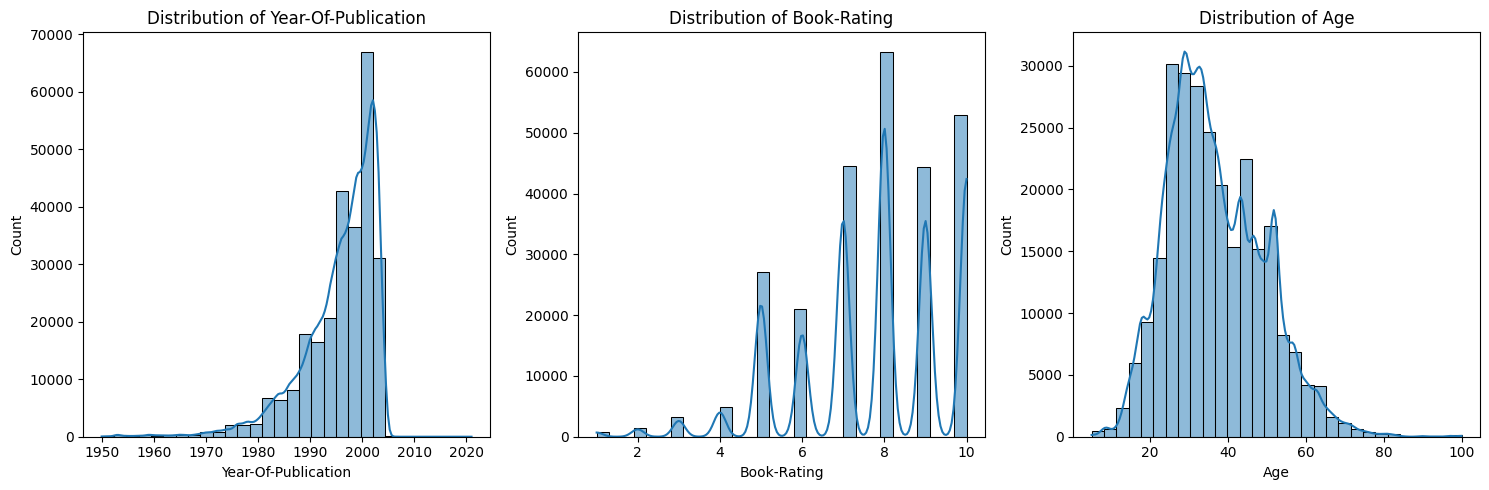

In [ ]:
numerical_cols = ['Year-Of-Publication', 'Book-Rating', 'Age']
categorical_cols = ['Book-Title', 'Book-Author', 'Location']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(books[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

- Mayoritas buku dalam dataset diterbitkan antara tahun 1995 hingga 2005, dengan puncak sekitar tahun 2002–2004. Hal ini menunjukkan bahwa dataset lebih merepresentasikan buku-buku modern pada masa tersebut, dan mungkin kurang representatif untuk buku klasik atau terbitan terbaru.
- Sebagian besar pengguna memberikan rating tinggi, terutama pada nilai 7, 8, 9, dan 10. Ini menunjukkan bahwa pengguna cenderung memberikan penilaian positif terhadap buku yang mereka baca, atau mungkin hanya memberikan rating pada buku yang mereka sukai. Pola ini bisa menimbulkan bias positif dalam evaluasi kualitas buku.
- Distribusi umur menunjukkan bahwa sebagian besar pengguna berada di rentang usia 20 hingga 40 tahun. Artinya, sistem ini paling banyak digunakan oleh generasi muda dan dewasa awal, yang kemungkinan besar memiliki preferensi tertentu terhadap genre atau jenis buku, sehingga dapat mempengaruhi pola rating dan konsumsi buku.
- Karena rating buku bersifat diskrit dan cenderung berat ke nilai tinggi, pemodelan sistem rekomendasi sebaiknya mempertimbangkan distribusi ini agar tidak terlalu bias terhadap buku-buku populer dengan rating tinggi.

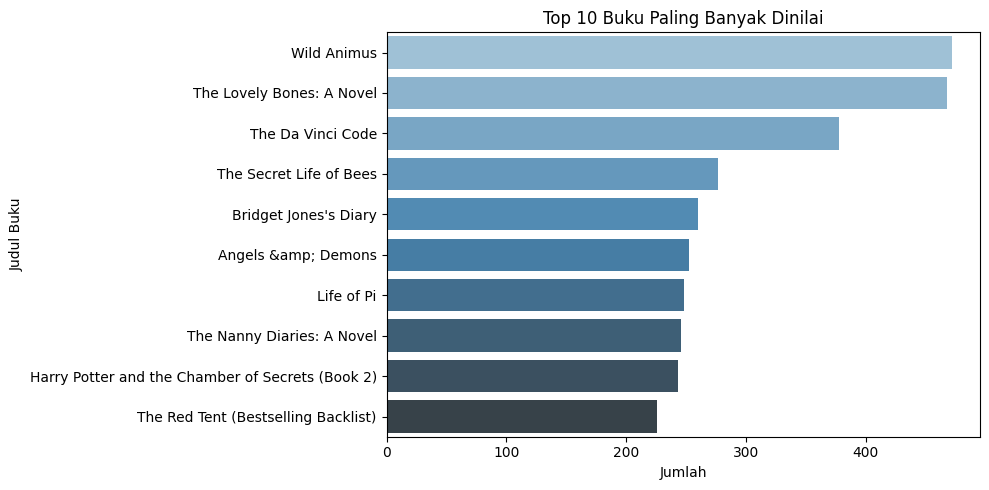

In [ ]:
top_books = books['Book-Title'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_books.values, y=top_books.index, palette="Blues_d")
plt.title("Top 10 Buku Paling Banyak Dinilai")
plt.xlabel("Jumlah")
plt.ylabel("Judul Buku")
plt.tight_layout()
plt.show()

Buku "Wild Animus" adalah buku yang paling banyak diberi rating, diikuti oleh "The Lovely Bones: A Novel" dan "The Da Vinci Code". Kesepuluh buku ini tampaknya memiliki tingkat popularitas tinggi di kalangan pengguna karena mendapatkan volume rating yang jauh lebih banyak dibandingkan buku lainnya dalam dataset.

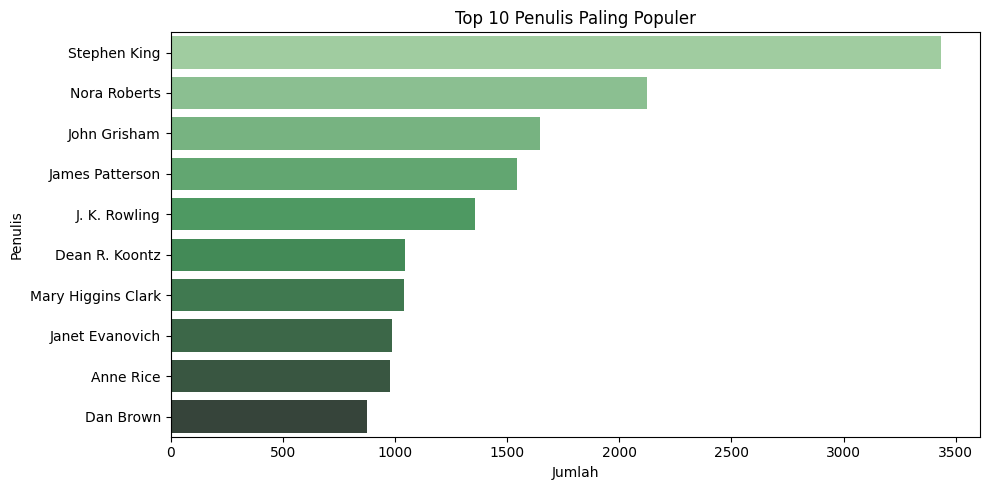

In [ ]:
top_authors = books['Book-Author'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_authors.values, y=top_authors.index, palette="Greens_d")
plt.title("Top 10 Penulis Paling Populer")
plt.xlabel("Jumlah")
plt.ylabel("Penulis")
plt.tight_layout()
plt.show()

Grafik menunjukkan bahwa Stephen King adalah penulis dengan jumlah rating terbanyak dalam dataset, diikuti oleh Nora Roberts, John Grisham, dan James Patterson. Sepuluh penulis yang ditampilkan memiliki jumlah penilaian yang signifikan dibandingkan penulis lain, yang menunjukkan bahwa buku-buku mereka banyak dinilai oleh pengguna. Hal ini mengindikasikan bahwa penulis-penulis ini termasuk yang paling sering muncul dalam data rating buku pengguna.

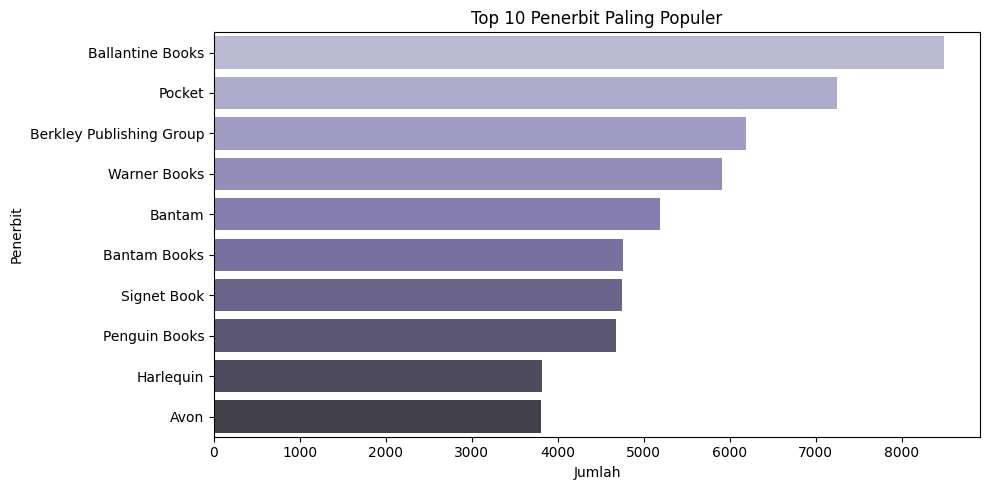

In [ ]:
top_publishers = books['Publisher'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_publishers.values, y=top_authors.index, palette="Purples_d")
plt.title("Top 10 Penerbit Paling Populer")
plt.xlabel("Jumlah")
plt.ylabel("Penerbit")
plt.tight_layout()
plt.show()

Berdasarkan grafik, Ballantine Books merupakan penerbit dengan jumlah rating terbanyak dalam dataset, disusul oleh Pocket dan Berkley Publishing Group. Sepuluh penerbit yang ditampilkan memiliki jumlah buku yang dinilai paling tinggi dibandingkan penerbit lainnya.

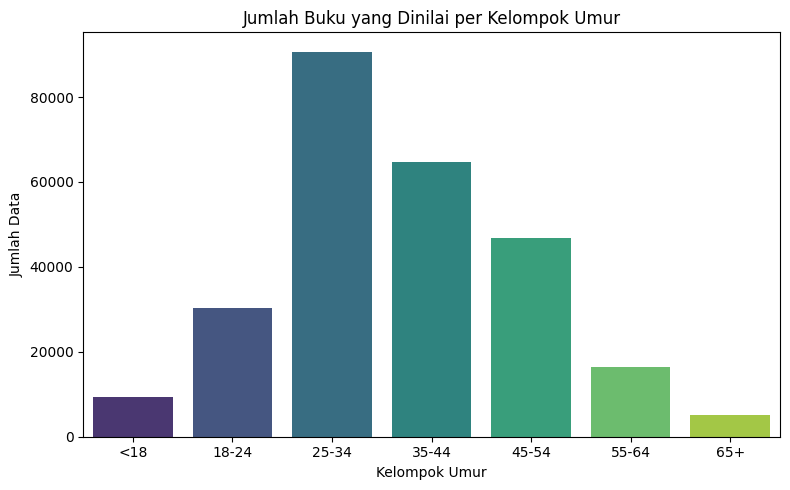

In [ ]:
bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
books['AgeGroup'] = pd.cut(books['Age'], bins=bins, labels=labels, right=False)

age_count = books['AgeGroup'].value_counts().sort_index()
plt.figure(figsize=(8,5))
sns.barplot(x=age_count.index, y=age_count.values, palette="viridis")
plt.title("Jumlah Buku yang Dinilai per Kelompok Umur")
plt.ylabel("Jumlah Data")
plt.xlabel("Kelompok Umur")
plt.tight_layout()
plt.show()

Kelompok usia 25–34 merupakan yang paling aktif dalam memberikan penilaian terhadap buku, dengan jumlah data tertinggi dibandingkan kelompok usia lainnya. Disusul oleh kelompok usia 35–44 dan 45–54. Aktivitas penilaian menurun signifikan pada kelompok usia di atas 55 tahun dan yang berusia di bawah 18 tahun, yang menunjukkan bahwa minat atau partisipasi dalam menilai buku lebih besar pada kalangan dewasa muda hingga paruh baya.

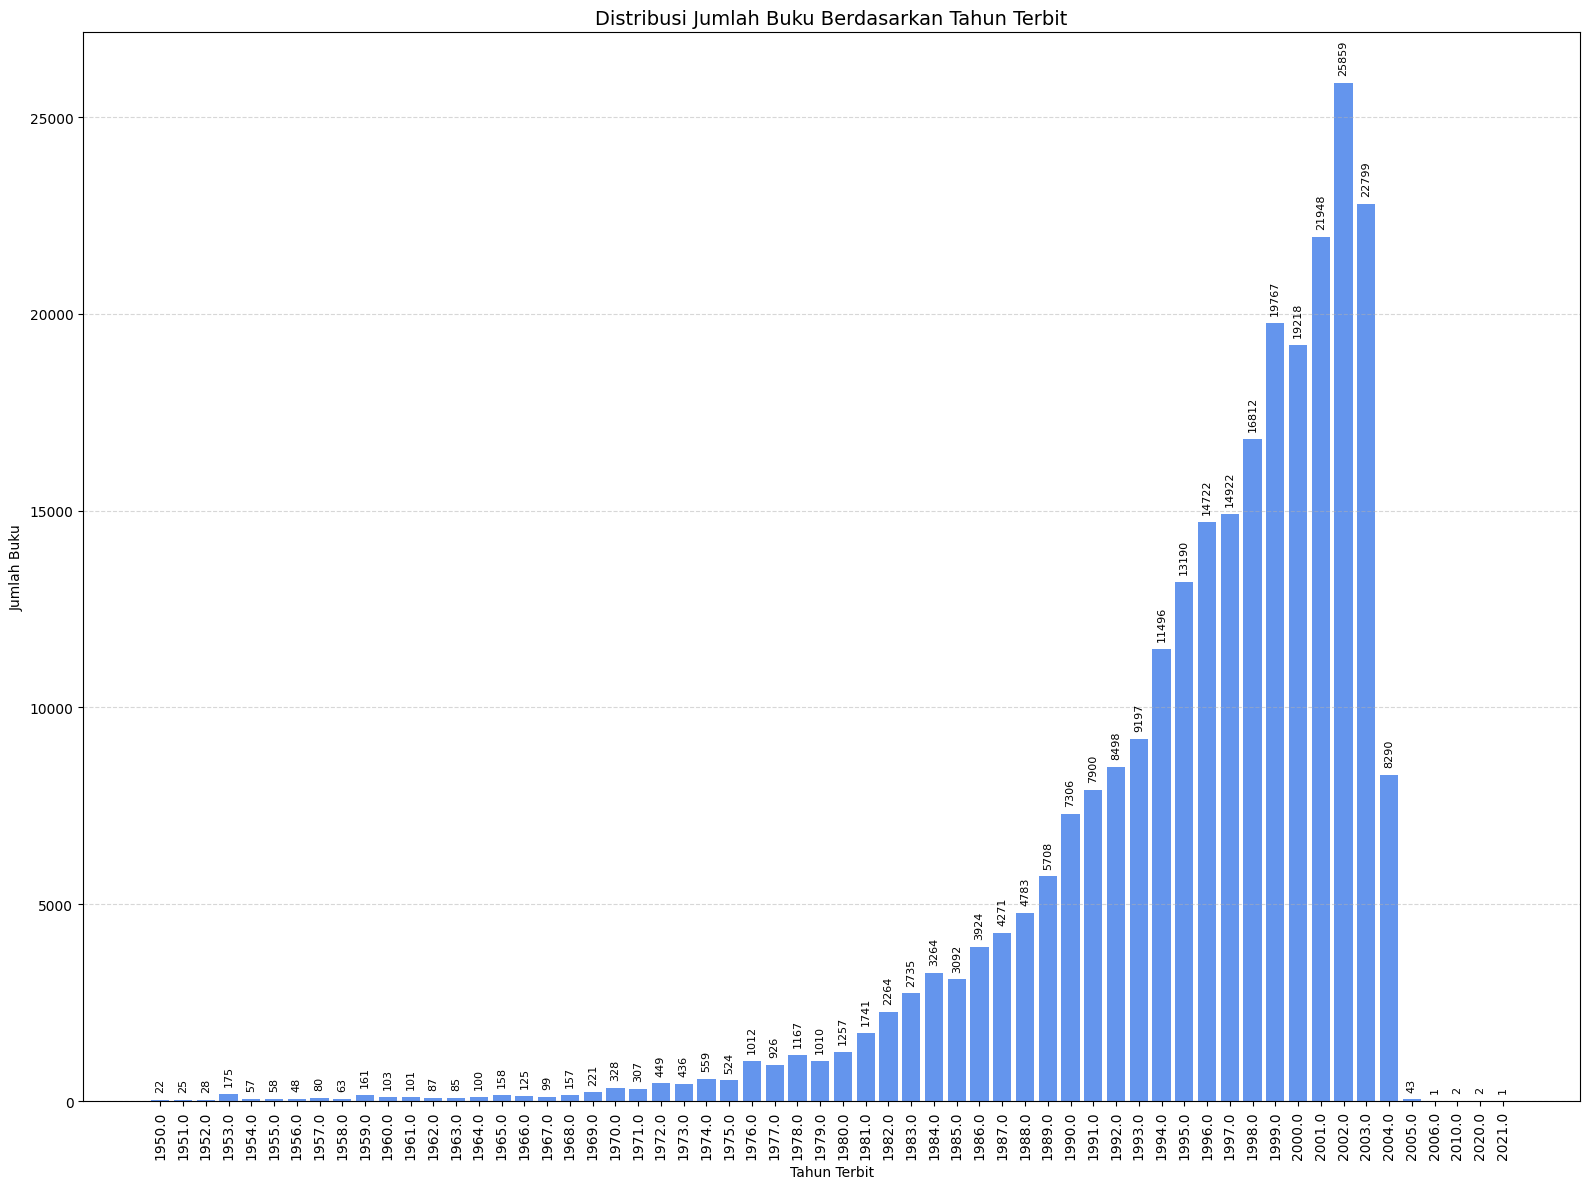

In [ ]:
books_per_year = books['Year-Of-Publication'].value_counts().sort_index()

plt.figure(figsize=(16, 12))
bars = plt.bar(books_per_year.index.astype(str), books_per_year.values, color='cornflowerblue')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 200,
        str(height),
        ha='center', va='bottom',
        rotation=90, fontsize=8
    )

plt.title('Distribusi Jumlah Buku Berdasarkan Tahun Terbit', fontsize=14)
plt.xlabel('Tahun Terbit')
plt.ylabel('Jumlah Buku')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Jumlah buku yang diterbitkan meningkat secara signifikan sejak tahun 1970-an, dengan puncaknya terjadi pada akhir 1990-an hingga awal 2000-an. Tahun 2002 mencatat jumlah buku terbanyak yang diterbitkan. Setelah itu, terjadi penurunan tajam dalam jumlah buku yang terdaftar. Ini menunjukkan adanya lonjakan besar dalam publikasi buku selama dekade terakhir abad ke-20 dan awal abad ke-21.

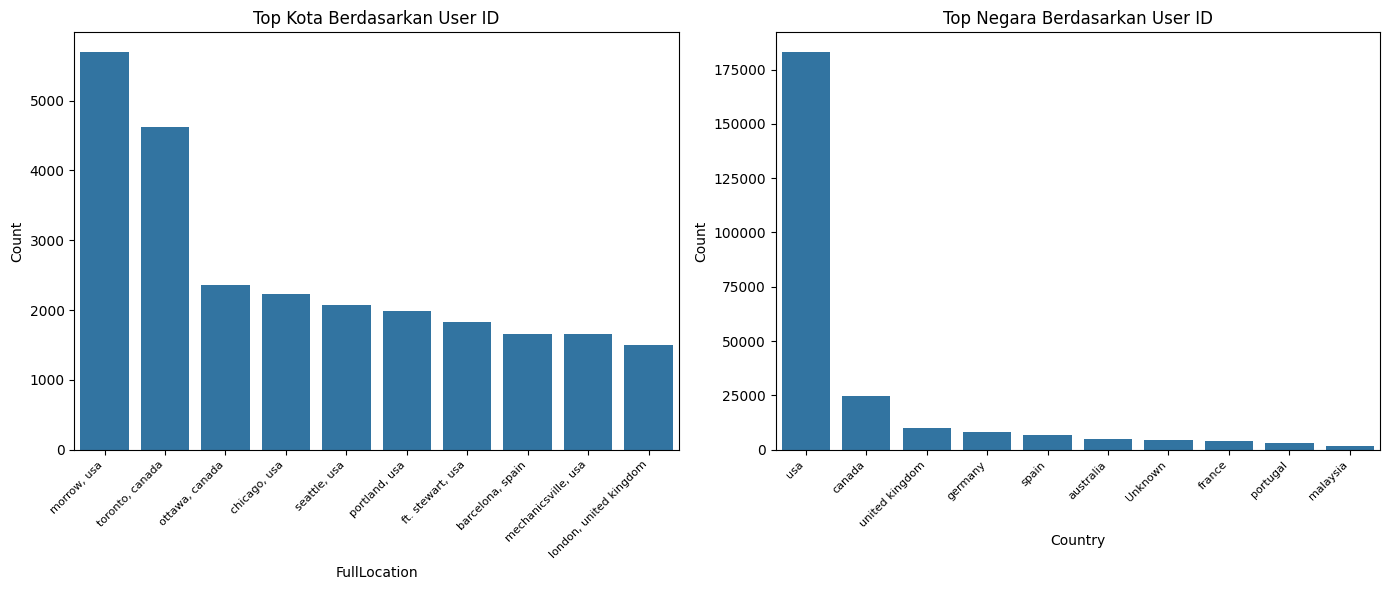

In [ ]:
# Split jadi maksimal 3 bagian (City, State, Country) meskipun ada yang kurang
split_location = books['Location'].str.split(', ', n=2, expand=True)

# Pastikan jumlah kolom hasil split-nya tetap 3 (isi yang kurang dengan None)
split_location = split_location.reindex(columns=[0, 1, 2])

# Assign ke kolom baru
books['City'] = split_location[0]
books['State'] = split_location[1]
books['Country'] = split_location[2]

# Gabungkan nama kota dan negara
books['FullLocation'] = books['City'] + ', ' + books['Country'].fillna('Unknown')

# Top 10 lokasi
top_locations = books['FullLocation'].value_counts().reset_index(name='Count').rename(columns={'index': 'FullLocation'}).head(10)

# Top 10 negara
top_countries = books['Country'].fillna('Unknown').value_counts().reset_index(name='Count').rename(columns={'index': 'Country'}).head(10)

# Visualisasi
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

# Change 'Location' to 'FullLocation'
sns.barplot(data=top_locations, x='FullLocation', y='Count', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', size=8)
ax1.set_title('Top Kota Berdasarkan User ID')

sns.barplot(data=top_countries, x='Country', y='Count', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', size=8)
ax2.set_title('Top Negara Berdasarkan User ID')

plt.tight_layout()
plt.show()

- Berdasarkan distribusi lokasi pengguna, kota dengan jumlah pengguna terbanyak adalah Morrow, USA, diikuti oleh Toronto dan Ottawa dari Kanada. Kota-kota lain yang mendominasi sebagian besar data berasal dari wilayah Amerika Serikat dan Kanada, dengan beberapa pengecualian seperti Barcelona, Spanyol dan London, United Kingdom. Ini menunjukkan bahwa interaksi terhadap buku dalam dataset ini banyak berasal dari kota-kota besar di wilayah berbahasa Inggris, khususnya di Amerika Utara.
- Dari sisi negara, data menunjukkan bahwa Amerika Serikat (USA) memiliki jumlah pengguna terbanyak secara signifikan, disusul oleh Kanada dan United Kingdom. Negara-negara lainnya seperti Jerman, Spanyol, dan Australia memiliki kontribusi yang jauh lebih kecil. Temuan ini menunjukkan bahwa mayoritas data berasal dari negara-negara berbahasa Inggris, terutama dari USA dan Kanada, yang mendominasi interaksi terhadap buku dalam dataset ini.

## **Data Preparation**

In [ ]:
# Filter pengguna dengan minimal 3 rating
user_rating_counts = book_data_clean['User-ID'].value_counts()
valid_users = user_rating_counts[user_rating_counts >= 3].index
filtered_data = book_data_clean[book_data_clean['User-ID'].isin(valid_users)].copy()

# Pilih user acak sampai total rating mendekati 30.000
selected_users = []
total_ratings = 0
for user_id in np.random.permutation(filtered_data['User-ID'].unique()):
    user_ratings = filtered_data[filtered_data['User-ID'] == user_id]
    if total_ratings + len(user_ratings) <= 30000:
        selected_users.append(user_id)
        total_ratings += len(user_ratings)
    if total_ratings >= 30000:
        break

book_sample = filtered_data[filtered_data['User-ID'].isin(selected_users)].copy().reset_index(drop=True)
print("📊 Jumlah total data:", len(book_sample))
print("📊 Jumlah rating minimum per user:", book_sample['User-ID'].value_counts().min())

📊 Jumlah total data: 30000
📊 Jumlah rating minimum per user: 3


In [ ]:
# Data Preparation Content Based Features
cb_data = book_sample.copy()
for col in ['Book-Title', 'Book-Author', 'Publisher']:
    cb_data[col] = cb_data[col].astype(str).str.lower().str.strip()
cb_data['content_features'] = (
    cb_data['Book-Title'] + ' ' +
    cb_data['Book-Author'] + ' ' +
    cb_data['Publisher'] + ' ' +
    cb_data['Year-Of-Publication'].astype(str) + ' ' +
    cb_data['Book-Rating'].astype(str)
)

In [ ]:
# Data Preparation Collaborative Features
cf_data = book_sample.copy()

# Label Encoding untuk user dan buku
user_encoder = LabelEncoder()
book_encoder = LabelEncoder()

cf_data['user_encoded'] = user_encoder.fit_transform(cf_data['User-ID'])
cf_data['book_encoded'] = book_encoder.fit_transform(cf_data['Book-Title'])

# Normalisasi rating ke skala 0–1
cf_data['rating_normalized'] = cf_data['Book-Rating'] / 10.0

# Split data 80:20
X_train, X_test, y_train, y_test = train_test_split(
    cf_data[['user_encoded', 'book_encoded']],
    cf_data['rating_normalized'],
    test_size=0.2,
    random_state=42
)

# Menyusun ulang DataFrame untuk dataset pelatihan dan pengujian
train_data = X_train.copy()
train_data['Book-Rating'] = y_train * 10

test_data = X_test.copy()
test_data['Book-Rating'] = y_test * 10

print("Train size:", len(train_data))
print("Test size:", len(test_data))

Train size: 24000
Test size: 6000


## **Modeling**

### Content Based filtering

In [ ]:
# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(cb_data['content_features'])

# K-Nearest Neighbors model
n_neighbors_list = [5, 10, 20, 30, 40]
best_knn = None
best_score = float('inf')

for n_neighbors in n_neighbors_list:
    knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric='cosine')
    knn.fit(tfidf_matrix)
    distances, indices = knn.kneighbors(tfidf_matrix)
    score = distances.mean()
    if score < best_score:
        best_score = score
        best_knn = knn

In [ ]:
from fuzzywuzzy import fuzz

# Rekomendasi
def recommend_cbf(query, top_n=5):
    query_idx = cb_data[cb_data['Book-Title'].apply(lambda x: fuzz.partial_ratio(x.lower(), query.lower()) > 90)].index
    if len(query_idx) == 0:
        print("❌ Judul tidak ditemukan.")
        return
    dists, indices = best_knn.kneighbors(tfidf_matrix[query_idx[0]], n_neighbors=top_n + 1)
    recommended_idx = indices[0][1:]
    scores = 1 - dists[0][1:]  # Ubah nilai hasil perhitungan cosine distance menjadi cosine similarity

    recommended_books = cb_data.iloc[recommended_idx][[
        'Book-Title', 'Book-Author', 'Publisher', 'Year-Of-Publication'
    ]].copy()
    recommended_books['Similarity'] = scores
    recommended_books = recommended_books.drop_duplicates().reset_index(drop=True)

    print(f"\nRekomendasi berdasarkan: '{query}':\n")
    print(recommended_books.head(top_n))

In [ ]:
recommend_cbf("PLEADING GUILTY", top_n=10)


Rekomendasi berdasarkan: 'PLEADING GUILTY':

                                          Book-Title           Book-Author  \
0                                    pleading guilty           scott turow   
1                                    burden of proof           scott turow   
2                         reversible errors: a novel           scott turow   
3  ultimate punishment : a lawyer's reflections o...           scott turow   
4                         that mighty sculptor, time  marguerite yourcenar   
5                                          the fixer       bernard malamud   
6                                         the pickup       nadine gordimer   
7                                         the pickup       nadine gordimer   

                   Publisher  Year-Of-Publication  Similarity  
0       farrar straus giroux               1993.0    0.969040  
1       farrar straus giroux               1990.0    0.761120  
2       farrar straus giroux               2002.0    0.7103

Didapat bahwa buku pertama yang direkomendasikan, "pleading guilty" oleh Scott Turow, memiliki tingkat kesamaan sebesar 0.969040, yang menunjukkan bahwa ini adalah buku yang paling mirip dengan kueri pengguna.

Selain itu, daftar rekomendasi mencakup beberapa buku dengan penulis yang sama (Scott Turow), yang menunjukkan bahwa algoritma ini tidak hanya mencari kesamaan berdasarkan judul, tetapi juga mengidentifikasi hubungan antar buku yang memiliki penulis atau tema serupa. Proses ini memungkinkan pengguna untuk menemukan buku yang relevan berdasarkan deskripsi atau metadata lain, seperti penulis atau penerbit, meskipun mereka tidak memiliki interaksi langsung dengan pengguna lain (seperti rating atau review).

### Collaborative Filtering

In [ ]:
from tensorflow.keras.regularizers import l2

# Dimensi embedding
EMBEDDING_SIZE = 50

# Definisikan model Collaborative Filtering menggunakan Embedding
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_books, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size

        # Embedding layers untuk users dan buku
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=l2(1e-5)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.book_embedding = layers.Embedding(
            num_books,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=l2(1e-5)
        )
        self.book_bias = layers.Embedding(num_books, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias = self.book_bias(inputs[:, 1])

        dot_user_book = tf.reduce_sum(user_vector * book_vector, axis=1, keepdims=True)
        x = dot_user_book + user_bias + book_bias
        return tf.nn.sigmoid(x)

num_users = cf_data['user_encoded'].nunique()
num_books = cf_data['book_encoded'].nunique()

# Inisialisasi model
model = RecommenderNet(num_users, num_books, EMBEDDING_SIZE)

# Build model dengan input shape=(None, 2)
model.build(input_shape=(None, 2))
model(tf.constant([[0, 0]]))

# Compile model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()

Model: "recommender_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (1, 50)                │        87,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (1, 1)                 │         1,746 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (1, 50)                │     1,061,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (1, 1)                 │        21,223 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,171,419 (4.47 MB)

 Trainable params: 1,171,419 (4.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Siapkan data pelatihan dan validasi
X_train_inputs = [train_data['user_encoded'], train_data['book_encoded']]
y_train_targets = train_data['Book-Rating'].astype(float)
X_val_inputs = [test_data['user_encoded'], test_data['book_encoded']]
y_val_targets = test_data['Book-Rating'].astype(float)

# Ubah input menjadi array numpy
import numpy as np
X_train_inputs = np.array(X_train_inputs).T
X_val_inputs = np.array(X_val_inputs).T

# Training model
history = model.fit(
    X_train_inputs,
    y_train_targets,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_inputs, y_val_targets),
    verbose=1
)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: -1.3318 - root_mean_squared_error: 7.4105 - val_loss: -0.5757 - val_root_mean_squared_error: 7.4592
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: -1.6392 - root_mean_squared_error: 7.3895 - val_loss: -0.6920 - val_root_mean_squared_error: 7.4554
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: -1.9221 - root_mean_squared_error: 7.3748 - val_loss: -0.8085 - val_root_mean_squared_error: 7.4516
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: -2.2686 - root_mean_squared_error: 7.3690 - val_loss: -0.9249 - val_root_mean_squared_error: 7.4478
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: -2.5970 - root_mean_squared_error: 7.3630 - val_loss: -1.0415 - val_root_mean_squared_error: 7.4440
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: -2.9357 - root_mean_squared_error: 7.3335 - val_loss: -1.1582 - val_root_mean_squared_error: 7.4403
Epoch 7/50
375/375 ━━━━━━━━━━

In [ ]:
# Rekomendasi
def recommend_ncf(user_id, top_n=5):
    if user_id not in user_encoder.classes_:
        print("❌ User ID tidak ditemukan.")
        return

    encoded_uid = user_encoder.transform([user_id])[0]
    books = np.arange(num_books)
    user_array = np.full(len(books), encoded_uid)

    # Buat satu tensor input dengan menggabungkan user_array dan books
    input_data = np.stack([user_array, books], axis=1)

    ratings = model.predict(input_data, verbose=0)
    top_books_idx = ratings.flatten().argsort()[-top_n:][::-1]
    recommended_titles = book_encoder.inverse_transform(top_books_idx)

    print(f"\nRekomendasi NCF untuk User ID {user_id}:\n")
    for title in recommended_titles:
        book = book_sample[book_sample['Book-Title'] == title]
        if not book.empty:
            print(f"• {title} ({book.iloc[0]['Book-Author']})")

In [ ]:
print(user_encoder.classes_)

[   114    242    272 ... 278137 278188 278551]


In [ ]:
recommend_ncf(278188, top_n=10)


Rekomendasi NCF untuk User ID 278188:

• One True Thing (Anna Quindlen)
• Grave Concerns (Mira) (Gwen Hunter)
• Kiss River (Mira) (Diane Chamberlain)
• The Delaney Woman (Jeanette Baker)
• Dreammaker (Harlequin Historicals, No. 486) (Judith Stacy)
• Baby-Sitters Island Adventure (Baby-Sitters Club Super Special, 4) (Ann M. Martin)
• Mary Anne's Bad-Luck Mystery (Baby-Sitters Club (Paperback)) (Ann M. Martin)
• Absolute Power (David Baldacci)
• Dawn on the Coast (Baby-Sitters Club (Paperback)) (Ann M. Martin)
• Karen's Goodbye (Baby-Sitters Little Sister, 19) (Ann M. Martin)


Sistem rekomendasi NCF untuk pengguna 278188 didominasi oleh beberapa judul dari penulis yang sama, seperti Ann M. Martin, dengan beberapa buku dari seri Baby-Sitters Club. Rekomendasi ini menunjukkan buku-buku yang diprediksi sesuai dengan preferensi pengguna berdasarkan pola interaksi pengguna sebelumnya dengan buku-buku yang telah diberi rating.

## **Evaluation**

### Evaluasi Content-Based Filtering (CBF)

In [ ]:
def evaluate_cbf_knn(user_ids, k=5, rating_threshold=7):
    precisions, recalls, f1_scores = [], [], []

    for uid in user_ids:
        liked_books = cb_data[(cb_data['User-ID'] == uid) & (cb_data['Book-Rating'] >= rating_threshold)]
        if liked_books.empty:
            continue

        query_title = liked_books.iloc[0]['Book-Title']
        query_idx = cb_data[cb_data['Book-Title'].str.lower().str.contains(query_title.lower())].index
        if len(query_idx) == 0:
            continue

        dists, indices = best_knn.kneighbors(tfidf_matrix[query_idx[0]], n_neighbors=k + 1)
        recommended_idx = indices[0][1:]
        recommended_titles = cb_data.iloc[recommended_idx]['Book-Title']

        hits = recommended_titles[recommended_titles.isin(liked_books['Book-Title'])]

        precision = len(hits) / k
        recall = len(hits) / len(liked_books)
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0.0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    # Evaluasi Precision@k, Recall@k, dan F1 Score@k
    print(f"\n📊 Content-Based Filtering Evaluation (Top-{k})")
    print(f"• Precision@{k}: {np.mean(precisions):.3f}")
    print(f"• Recall@{k}: {np.mean(recalls):.3f}")
    print(f"• F1-Score@{k}: {np.mean(f1_scores):.3f}")

sample_users = cb_data['User-ID'].drop_duplicates().sample(100, random_state=42)
evaluate_cbf_knn(sample_users, k=10, rating_threshold=5)


📊 Content-Based Filtering Evaluation (Top-10)
• Precision@10: 0.265
• Recall@10: 0.454
• F1-Score@10: 0.291


Pada sistem rekomendasi berbasis konten (content-based filtering), model dievaluasi menggunakan metrik Precision@10, Recall@10, dan F1-Score@10. Nilai Precision@10 sebesar 0.265 menunjukkan bahwa sekitar 26,5% dari 10 item teratas yang direkomendasikan oleh sistem memang relevan bagi pengguna. Sementara itu, Recall@10 sebesar 0.454 berarti sistem berhasil menangkap sekitar 45,4% dari total item relevan yang tersedia untuk pengguna. Nilai F1-Score@10 sebesar 0.291 merupakan harmonisasi dari precision dan recall, yang mencerminkan keseimbangan antara keduanya. Secara umum, nilai-nilai ini menunjukkan bahwa sistem mampu memberikan rekomendasi yang cukup relevan, namun masih memiliki ruang untuk peningkatan terutama dalam aspek presisi.

### Evaluasi Collaborative Filtering (CF)

In [ ]:
# Prediksi rating dari data uji
y_pred_normalized = model.predict(X_val_inputs, verbose=0).flatten()
y_pred = y_pred_normalized * 10  # skala balik ke 0-10
y_true = y_val_targets.values

# Evaluasi MAE dan RMSE
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"📊 Evaluation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

📊 Evaluation Metrics:
MAE  : 1.7979
RMSE : 2.1916


Dengan nilai **MAE sebesar 1.7979** dan **RMSE sebesar 2.1916**, model menunjukkan performa prediksi yang cukup baik. Rata-rata kesalahan prediksi rating hanya sekitar 1.8 poin, dan RMSE yang berada di kisaran 2.2 mengindikasikan bahwa sebagian besar prediksi tidak terlalu jauh meleset dari nilai sebenarnya. Nilai error yang relatif rendah ini menandakan bahwa model cukup akurat dalam mempelajari pola preferensi pengguna, dan sudah berada pada level performa yang layak untuk digunakan dalam sistem rekomendasi.

## **Conclusion**

Proyek ini bertujuan membangun sistem rekomendasi buku untuk membantu pengguna menemukan bacaan yang relevan dengan preferensinya, menggunakan data Book Recommendation Dataset dari Kaggle. Dua pendekatan yang digunakan, yaitu Content-Based Filtering (CBF) yang memanfaatkan kemiripan konten buku, dan Neural Collaborative Filtering (NCF) yang mempelajari pola interaksi pengguna-item. Pemilihan metode ini disesuaikan dengan kebutuhan personalisasi rekomendasi dan tantangan data yang dihadapi.

Hasil evaluasi menunjukkan bahwa CBF mencapai Precision@10 sebesar 26,5% dan Recall@10 sebesar 45,4%, menandakan relevansi rekomendasi yang cukup baik namun masih bisa ditingkatkan dari sisi presisi. Sementara itu, NCF menghasilkan MAE 1.7979 dan RMSE 2.1916, menunjukkan akurasi prediksi rating yang memadai. Secara keseluruhan, kedua model telah memberikan hasil yang sesuai dengan tujuan proyek, namun perbaikan lebih lanjut seperti tuning model atau penggabungan metode (hybrid) masih terbuka sebagai peluang pengembangan.